In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
from datetime import datetime
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from scipy.special import gamma,erf,erfc

In [2]:
!pwd


/home/nwoofter/sipm-analysis


In [2]:
data_dir = '/scratch/gpfs/nwoofter/results/2023-06-07/*/'
glob.glob(data_dir)

[]

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [5]:
# data folder
path = "/scratch/gpfs/nwoofter/results/2023-06-07/"
data = {}
intensity = [1020]
channels = [0, 1, 2]
voltages = 90
for intn in intensity:
    data[intn] = {}
    for ch in channels:
        data[intn][ch] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
        files = glob.glob(f"{path}/*intensity_{intn}*_wf.h5")
        print(files)
        for f in files:
            df = pd.read_hdf(f, key=f'{voltages}/{ch}')
            print(df)
            data[intn][ch]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
            if data[intn][ch]['time'].shape[0]==0:
                data[intn][ch]['time'] = np.array(df['time'])
            if data[intn][ch]['avg_spe_wf'].shape[0]==0:
                data[intn][ch]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            else:
                data[intn][ch]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            df = None
            data[intn][ch]['avg_spe_wf'] /= data[intn][ch]['n_spe_wfs']
print('keys: ', list(data[1020][0].keys()))

['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0_wf.h5']
      n_spe_wfs  avg_spe_wf    time
0       14630.0   -0.495014   0.000
1           NaN    0.516879   0.004
2           NaN   -0.507728   0.008
3           NaN    0.540461   0.012
4           NaN   -0.493920   0.016
...         ...         ...     ...
3995        NaN    0.578534  15.980
3996        NaN   -0.529874  15.984
3997        NaN    0.502457  15.988
3998        NaN   -0.492417  15.992
3999        NaN    0.563223  15.996

[4000 rows x 3 columns]
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0_wf.h5']
      n_spe_wfs  avg_spe_wf    time
0       16751.0   -0.442159   0.000
1           NaN    0.337197   0.004
2           NaN   -0.567943   0.008
3           NaN    0.435759   0.012
4           NaN   -0.397027   0.016
...         ...         ...     ...
3995        NaN    0.

In [6]:
intn = 1020
ch = 0
volt = 90
data[intn][ch]

{'n_spe_wfs': 14630.0,
 'avg_spe_wf': array([-0.49501398,  0.51687939, -0.50772759, ...,  0.50245697,
        -0.49241658,  0.56322252]),
 'time': array([0.0000e+00, 4.0000e-03, 8.0000e-03, ..., 1.5988e+01, 1.5992e+01,
        1.5996e+01])}

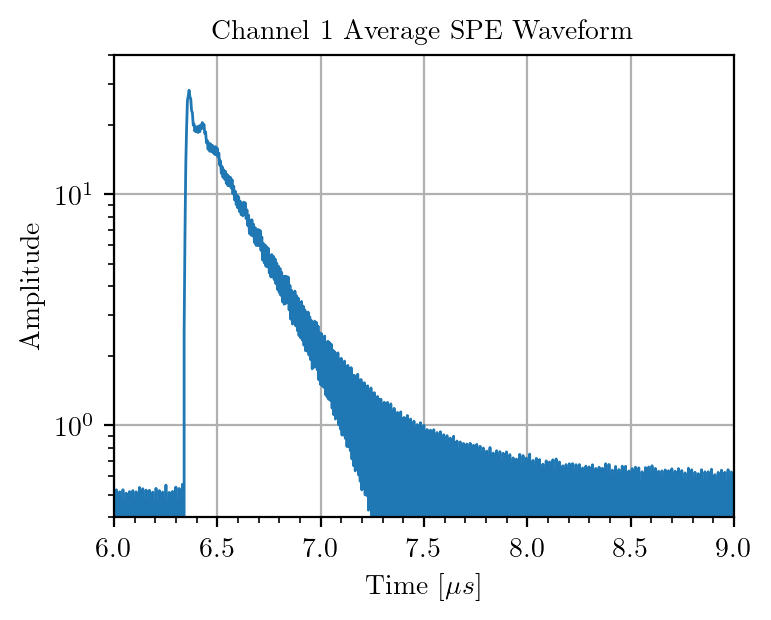

In [7]:
intn = 1020
ch = 0

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 1 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(6, 9)
plt.ylim(0.4, 40)
plt.grid()

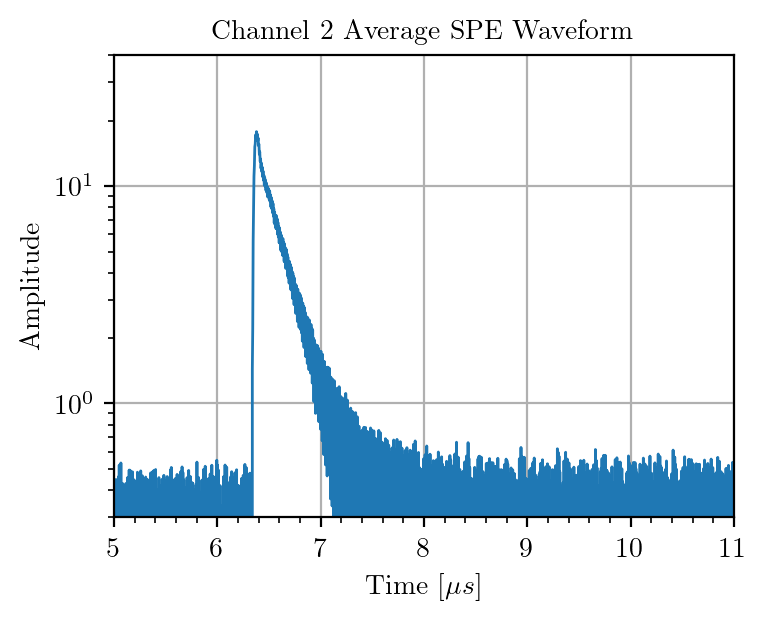

In [43]:
intn = 1020
ch = 1

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 2 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(5, 11)
plt.ylim(0.3, 40)
plt.grid()

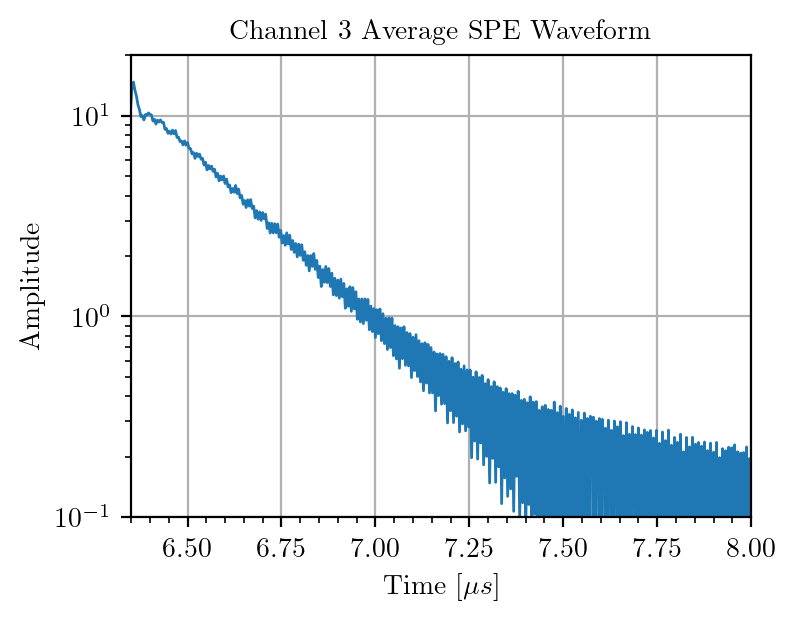

In [59]:
intn = 1020
ch = 2

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 3 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(6.35, 8)
plt.ylim(0.1, 20)
plt.grid()

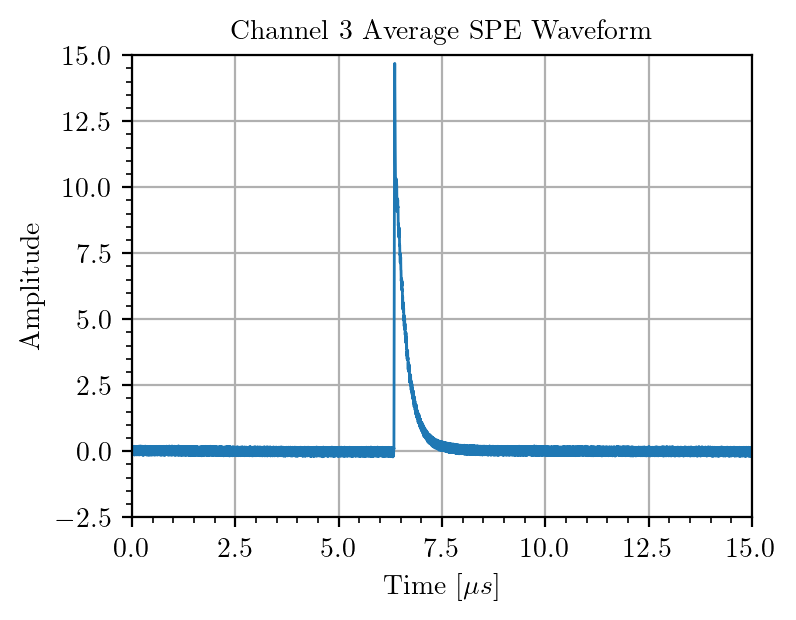

In [9]:
intn = 1020
ch = 1

#plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
#plt.plot(data[intn][1]['time'], data[intn][1]['avg_spe_wf'], linewidth = '1')
plt.plot(data[intn][2]['time'], data[intn][2]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 3 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.xlim(0, 15)
plt.grid()

In [73]:
def pulse_jitter_t0(t, a, tau, sigma):
    return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-6.34)/tau)*(1+erf((t-6.34-sigma**2/tau)/sigma/np.sqrt(2)))/2

In [74]:
def template(t, a_1, tau_1, a_2, tau_2, sigma):
        return pulse_jitter_t0(t, a_1, tau_1, sigma) + pulse_jitter_t0(t, a_2, tau_2, sigma)

In [75]:
intn = 1020
ch = 2

pretrg = 5 #us
err = np.std(data[intn][ch]['avg_spe_wf'][data[intn][ch]['time']<pretrg])
fit_range = [6.4,9] #us
range_arr = (data[intn][ch]['time']<fit_range[1])&(data[intn][ch]['time']>fit_range[0])
print(intn,ch)
# print(data[intn][ch]['time'][range_arr])
# print(data[intn][ch]['avg_spe_wf'][range_arr])
popt,pcov = curve_fit(
    template,
    data[intn][ch]['time'][range_arr], 
    data[intn][ch]['avg_spe_wf'][range_arr], 
    p0=[8, 0.2, 6, 0.3, 0.008], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
data[intn][ch]['pars'] = popt
data[intn][ch]['cov'] = pcov
print(popt)

1020 2
[13.13511341  0.23973891  0.19758186  1.2192359   0.03918425]


/tmp/ipykernel_1050403/164247002.py:2: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-6.34)/tau)*(1+erf((t-6.34-sigma**2/tau)/sigma/np.sqrt(2)))/2
/tmp/ipykernel_1050403/164247002.py:2: RuntimeWarning: invalid value encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-6.34)/tau)*(1+erf((t-6.34-sigma**2/tau)/sigma/np.sqrt(2)))/2


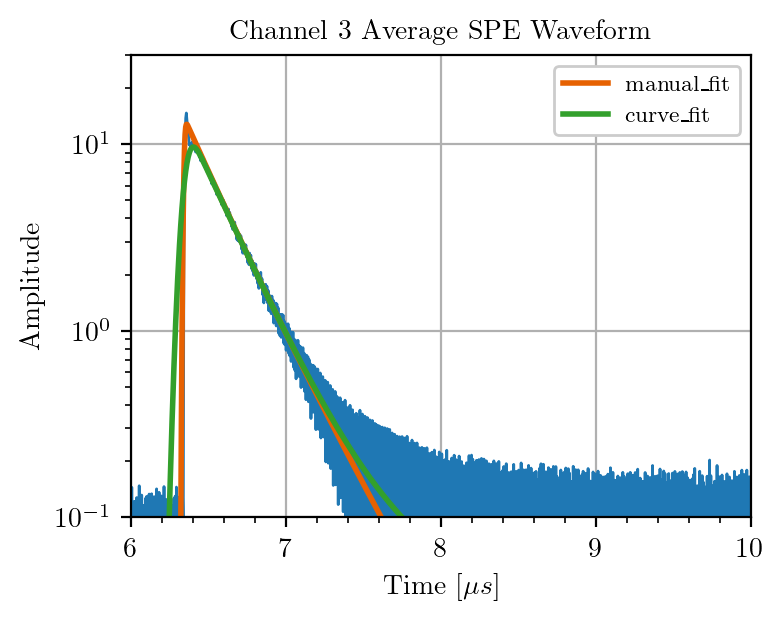

In [78]:
intn = 1020
ch = 2


#plt.plot(data[intn][ch]['pars'], data[intn][ch]['cov'], linewidth = '1')
plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.plot(data[intn][ch]['time'], template(data[intn][ch]['time'], 8, 0.2, 6, 0.3, 0.008), label = 'manual_fit')
plt.plot(data[intn][ch]['time'], template(data[intn][ch]['time'],
                                           13.1351134, 0.23973891, 0.19758186, 1.2192359, 0.03918425), label = 'curve_fit')
plt.minorticks_on()
plt.legend(loc = 'upper right')
plt.title('Channel 3 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(6, 10)
plt.ylim(0.1, 30)
plt.grid()

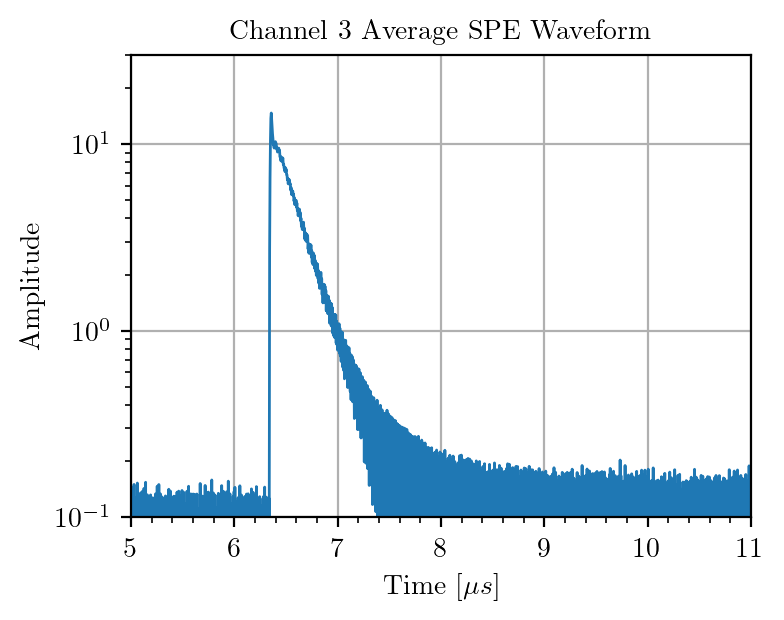

In [16]:
intn = 1020
ch = 2

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 3 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(5, 11)
plt.ylim(0.1, 30)
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TypeError: 'int' object is not subscriptable

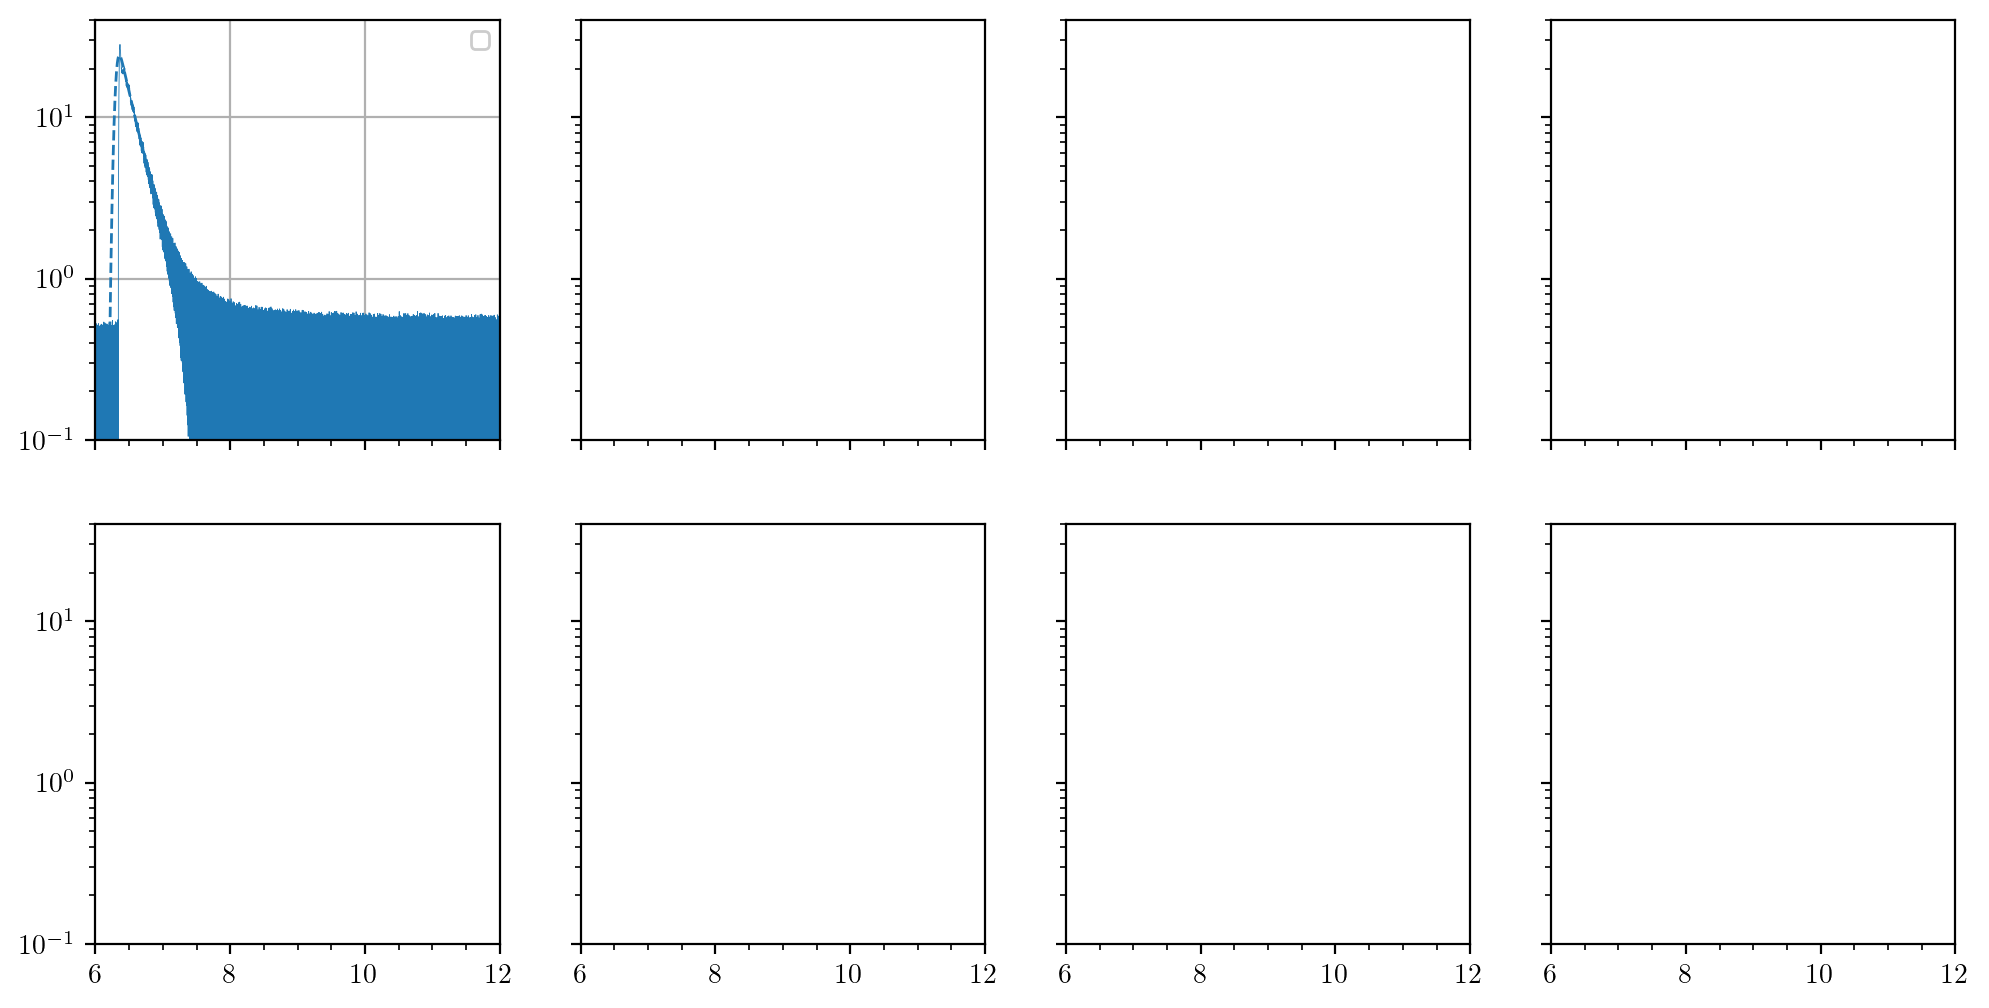

In [13]:
# Make plots for all datasets
# Fitted SPE average waveform
k = 90
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, intn in enumerate(intensity):
    for j, ch in enumerate(channels):
        axs[i, j].plot(
            data[intn][ch]['time'],
            data[intn][ch]['avg_spe_wf'],
            color=f'C{k}', linewidth=0.3)
        axs[i, j].plot(
            data[intn][ch]['time'],
            template(data[intn][ch]['time'], *data[intn][ch]['pars']), 
            color=f'C{k}', linestyle='--', linewidth=1)
        axs[i, j].legend(loc='upper right',ncol=2)
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(0.1, 40)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{intn[0].upper()}{intn[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)

In [4]:
# data folder
path = "/scratch/gpfs/nwoofter/results/2023-06-07/"
data = {}
intensity = [500]
channels = [0, 1, 2, 3]
voltages = 60
for intn in intensity:
    data[intn] = {}
    for ch in channels:
        data[intn][ch] = {'n_0pe_wfs':0, 'avg_0pe_psd':np.zeros(0), 'frequency_MHz':np.zeros(0)}
        files = glob.glob(f"{path}/*intensity_{intn}*_fft_below_breakdown.h5")
        print(files)
        for f in files:
            df = pd.read_hdf(f, key=f'{voltages}/{ch}')
            print(df)
            data[intn][ch]['n_0pe_wfs'] += np.array(df['n_0pe_wfs'])[0]
            if data[intn][ch]['frequency_MHz'].shape[0]==0:
                data[intn][ch]['frequency_MHz'] = np.array(df['frequency_MHz'])
            if data[intn][ch]['avg_0pe_psd'].shape[0]==0:
                data[intn][ch]['avg_0pe_psd'] = np.array(df['avg_0pe_psd'])*np.array(df['n_0pe_wfs'])[0]
            else:
                data[intn][ch]['avg_0pe_psd'] += np.array(df['avg_0pe_psd'])*np.array(df['n_0pe_wfs'])[0]
            df = None
            data[intn][ch]['avg_0pe_psd'] /= data[intn][ch]['n_0pe_wfs']
print('keys: ', list(data[500][0].keys()))

['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_60_light_laser_cond_ln_long_intensity_500_config_1_intensity_500_run0_fft_below_breakdown.h5']
        frequency_MHz  n_0pe_wfs   avg_0pe_psd
0               0.000      295.0  2.755650e+08
1               0.001        NaN  1.847653e+08
2               0.002        NaN  7.866045e+07
3               0.003        NaN  5.728086e+07
4               0.004        NaN  4.945026e+07
...               ...        ...           ...
249995        249.995        NaN  4.097332e+07
249996        249.996        NaN  4.945026e+07
249997        249.997        NaN  5.728086e+07
249998        249.998        NaN  7.866045e+07
249999        249.999        NaN  1.847653e+08

[250000 rows x 3 columns]
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_60_light_laser_cond_ln_long_intensity_500_config_1_intensity_500_run0_fft_below_breakdown.h5']
        frequency_MHz  n_0pe_wfs   avg_0pe_psd
0               0.000      295.0  1.525503e+10
1    

/tmp/ipykernel_989026/1742714872.py:15: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 125)


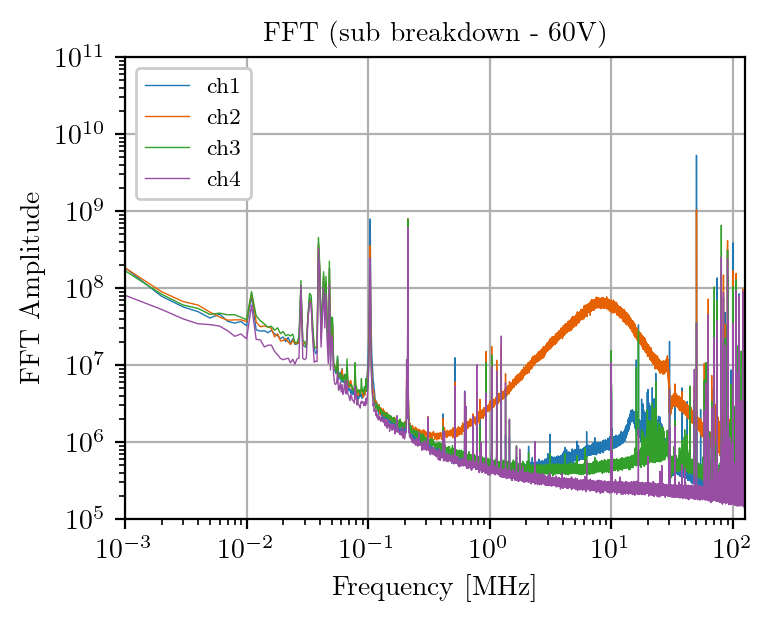

In [14]:
intn = 500
ch = 0

plt.plot(data[intn][ch]['frequency_MHz'], data[intn][ch]['avg_0pe_psd'], label = 'ch1', linewidth = '0.5')
plt.plot(data[intn][ch]['frequency_MHz'], data[intn][1]['avg_0pe_psd'], label = 'ch2',linewidth = '0.5')
plt.plot(data[intn][ch]['frequency_MHz'], data[intn][2]['avg_0pe_psd'], label = 'ch3',linewidth = '0.5')
plt.plot(data[intn][ch]['frequency_MHz'], data[intn][3]['avg_0pe_psd'], label = 'ch4',linewidth = '0.5')
plt.minorticks_on()
plt.legend()
plt.title('FFT (sub breakdown - 60V)')
plt.xlabel(r'Frequency [MHz]')
plt.ylabel('FFT Amplitude')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0, 125)
#plt.ylim(0.4, 40)
plt.grid()